# Setup

## Imports & Settings

In [43]:
%load_ext autoreload
%autoreload 2

import os
import re
import itertools
import scipy
import scanpy as sc
import seaborn as sb
import pandas as pd
import numpy as np
import corescpy as cr

# Computing Resources
gpu = False
sc.settings.n_jobs = 8
sc.settings.max_memory = 150

# Display
pd.options.display.max_colwidth = 1000
pd.options.display.max_columns = 100
pd.options.display.max_rows = 500
sc.settings.set_figure_params(dpi=100, frameon=False, figsize=(20, 20))

# Panel & Column Names (from Metadata & To Be Created)
panel = "XR4UZH"
# panel = "TUQ97N"
suffix = ""  # no file suffix for object h5ad file (main object)
capitalize_sample = True if panel == "TUQ97N" else False
# suffix = "_new"  # suffix for object h5ad file (to avoid overwrite)

# Samples/Runs
run = None  # just look for samples in all Xenium runs for the panel
# run = "CHO-001"  # run all from this run; so don't have to specify samples
samples = "all"

# Main Directories
# Replace manually or mirror my file/directory tree in your home (`ddu`)
ddu = os.path.expanduser("~")
ddm = "/mnt/cho_lab" if os.path.exists("/mnt/cho_lab") else "/mnt"  # Spark?
ddl = f"{ddm}/disk2/{os.getlogin()}/data/shared-xenium-library" if (
    "cho" in ddm) else os.path.join(ddu, "shared-xenium-library")
ddx = f"{ddm}/bbdata2"  # mounted drive Xenium folder
out_dir = os.path.join(ddl, "outputs", panel, "nebraska")  # to save objects
out_dir_plot = os.path.join(out_dir, "plots")  # plot directory
out_subdir_markers = "find_markers"  # sub-directory under out_dir for markers
# out_dir = None  # don't save
file_mdf = os.path.join(ddl, f"samples_{panel}.csv")  # metadata file path

# Automated Annotation Options
file_ann = None  # to skip marker-based annotation
# file_ann = os.path.join(ddu, "corescpy/examples/markers_lineages.csv")
col_assignment = None  # column in annotation file whose labels to use
# col_assignment = "Bin"
# col_assignment = ["group", "Bin", "Bin"]  # (order corresponds to res_list)

# Preprocessing Options
outlier_mads = {"n_counts": [1.25, None]}
kws_pp = dict(cell_filter_ngene=[3, None], gene_filter_ncell=[3, None],
              gene_filter_ncounts=[3, None], custom_thresholds=None,
              kws_scale=dict(max_value=10, zero_center=True),
              outlier_mads=outlier_mads, method_norm="log")  # preprocessing
# kws_pp = dict(cell_filter_pmt=None, cell_filter_ncounts=[15, None],
#               cell_filter_ngene=[3, None], gene_filter_ncell=[3, None],
#               gene_filter_ncounts=[3, None], custom_thresholds=None,
#               kws_scale=dict(max_value=10, zero_center=True),
#               method_norm="log")  # preprocessing keyword arguments
# kws_pp = None   # if loading object already preprocessed

# Clustering Options
genes_subset = None  # subset genes used in clustering?
# genes_subset = list(pd.read_csv(file_ann).iloc[:, 0])  # only cell markers
kws_cluster = dict(kws_umap=dict(method="rapids" if gpu else "umap"),
                   genes_subset=genes_subset,  # use only markers
                   use_gpu=gpu, use_highly_variable=False)
# res_list = [1.5, 0.75, 0.5]  # resolutions (iterate clustering runs)
# min_dist_list = [0, 0.3, 0.5]  # distances (order corresponds to res_list)
# n_comps_list = [30, 30, 30]  # PCA components (order same as res_list)
res_list = [1.5, 0.5]  # resolutions (iterate different clustering runs)
min_dist_list = [0, 0.5]  # distances (order corresponds to res_list)
n_comps_list = [30, 30]  # PCA components (order corresponds to res_list)
kws_clustering_spatial = None  # specify to perform spatial clustering
suffix_clustering_spatial = None  # column key for spatial clustering results
# ^ should parallel the parameters, like normal clustering does
# e.g., res0pt75_dist0pt3_npc30

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setup

Get constants (e.g., column names in metadata), read metadata, create dictionary of clustering parameters (so can iterate across different clustering specifications to make multiple versions, e.g., at multiple resolutions) using `res_list`, `min_dist_list`, and `n_comps_list`, make any output directories (e.g., for processed objects, plots, find markers results, Xenium Explorer cluster files) if any don't exist yet, load data into objects, etc.

In [ ]:
# Get Constants
constants_dict = cr.get_panel_constants(panel)
col_sample_id_o, col_sample_id, col_condition, col_inflamed, col_subject = [
    constants_dict[x] if x in constants_dict else None for x in [
        "col_sample_id_o", "col_sample_id", "col_condition",
        "col_inflamed", "col_subject"]]
col_stricture, key_stricture, col_f, col_tangram, col_segment, col_object = [
    constants_dict[x] if (x in constants_dict) else None for x in [
        "col_stricture", "key_stricture", "col_data_dir",
        "col_tangram", "col_segment", "col_object"]]

# Construct Clustering Keyword Dictionary
kws_clustering = {}
for i in zip(res_list, min_dist_list, n_comps_list):
    kws = {**kws_cluster}
    kws.update({"resolution": i[0], "n_comps": i[2],
                "kws_umap": {**kws_cluster["kws_umap"], "min_dist": i[1]}})
    suff = str(f"res{re.sub('[.]', 'pt', str(kws['resolution']))}_dist"
               f"{re.sub('[.]', 'pt', str(kws['kws_umap']['min_dist']))}"
               f"_npc{kws['n_comps']}")  # file path suffix
    kws_clustering.update({suff: kws})

# Read Metadata
metadata = cr.pp.get_metadata_cho(
    ddx, file_mdf, panel_id=panel, samples=samples, run=run,
    capitalize_sample=capitalize_sample)  # get metadata
print("\n\n", metadata[list(set([
    col_sample_id_o, col_subject, col_condition, col_inflamed, col_stricture,
    col_segment]).intersection(metadata))])

# Annotation File
assign = pd.read_csv(file_ann).dropna(subset=col_assignment).set_index(
    "gene").rename_axis("Gene") if file_ann is not None else None
# assign = assign[~assign.Quality.isin([-1])]  # drop low-quality markers
if col_assignment is not None and isinstance(col_assignment, str):
    col_assignment = [col_assignment] * len(res_list)  # same for each version

# Create Objects
[os.makedirs(x, exist_ok=True) for x in [
    out_dir, out_dir_plot, out_subdir_markers] if x]  # make out directories
kws_init = dict(col_sample_id=col_sample_id, col_subject=col_subject,
                col_cell_type=f"leiden_{list(kws_clustering.keys())[0]}")
selves = [None] * metadata.shape[0]  # to hold different samples
for i, x in enumerate(metadata.index.values):
    out = os.path.join(out_dir, x + suffix)  # object output path

    # Ensure No Overwrite of Prior Preprocessing or Skipping Preprocessing
    # without Loading Prior Preprocessed Object
    if os.path.exists(out + ".h5ad"):  # if processed object file exists...
        if kws_pp is not None:  # don't overwrite with new preprocessing
            raise ValueError(f"\n\nProcessed object already exists!\n{out}.\n"
                             "specify different file suffix, or set `kws_pp` "
                             "to None to reload processed object.")
    elif kws_pp is None:  # if doesn't exist but pp parameters specified...
        raise ValueError(f"\n\nProcessed object doesn't exist!\n{out}.\n"
                         "Specify `kws_pp` to perform new proprocessing "
                         "or ensure processed object paths are correct.")

    # Load Data into Object (Update with Prior Preprocessed Object if Exists)
    selves[i] = cr.Spatial(metadata.loc[x][col_f], library_id=x, **kws_init)
    if os.path.exists(out + ".h5ad") and kws_pp is None:
        selves[i].update_from_h5ad(out)  # update with prior preprocessing

    # Add metadata to object
    for j in metadata.dropna(how="all", axis=1):  # add metadata to .obs
        selves[i].rna.obs.loc[:, j] = str(metadata.loc[x][j])
    selves[i].rna.obs.loc[:, col_object] = out  # path for processed object

# Clustering

## Processing, Leiden, Annotation



 {'cell_filter_ngene': [3, None], 'gene_filter_ncell': [3, None], 'gene_filter_ncounts': [3, None], 'custom_thresholds': None, 'kws_scale': {'max_value': 10, 'zero_center': True}, 'outlier_mads': {'n_counts': [1.25, None]}, 'method_norm': 'log'} 


AnnData object with n_obs × n_vars = 1104361 × 480
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'z_level', 'nucleus_count', 'cell_labels', 'Sample', 'sourceID', 'sampleID', 'location', 'slide_ID', 'clinical_block', 'description', 'grid', 'inflamed', 'age', 'sex', 'race', 'hispanic', 'diagnosis', 'project', 'disease_status', 'procedure', 'project_owner_id', 'cca_or_hcc', 'psc_stage', 'psc_diag_year', 'ibd_status', 'ibd_diag_year', 'vital_status', 'file_path', 'out_file', 'n_obs_raw'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs', 'spatial', 'original_ix

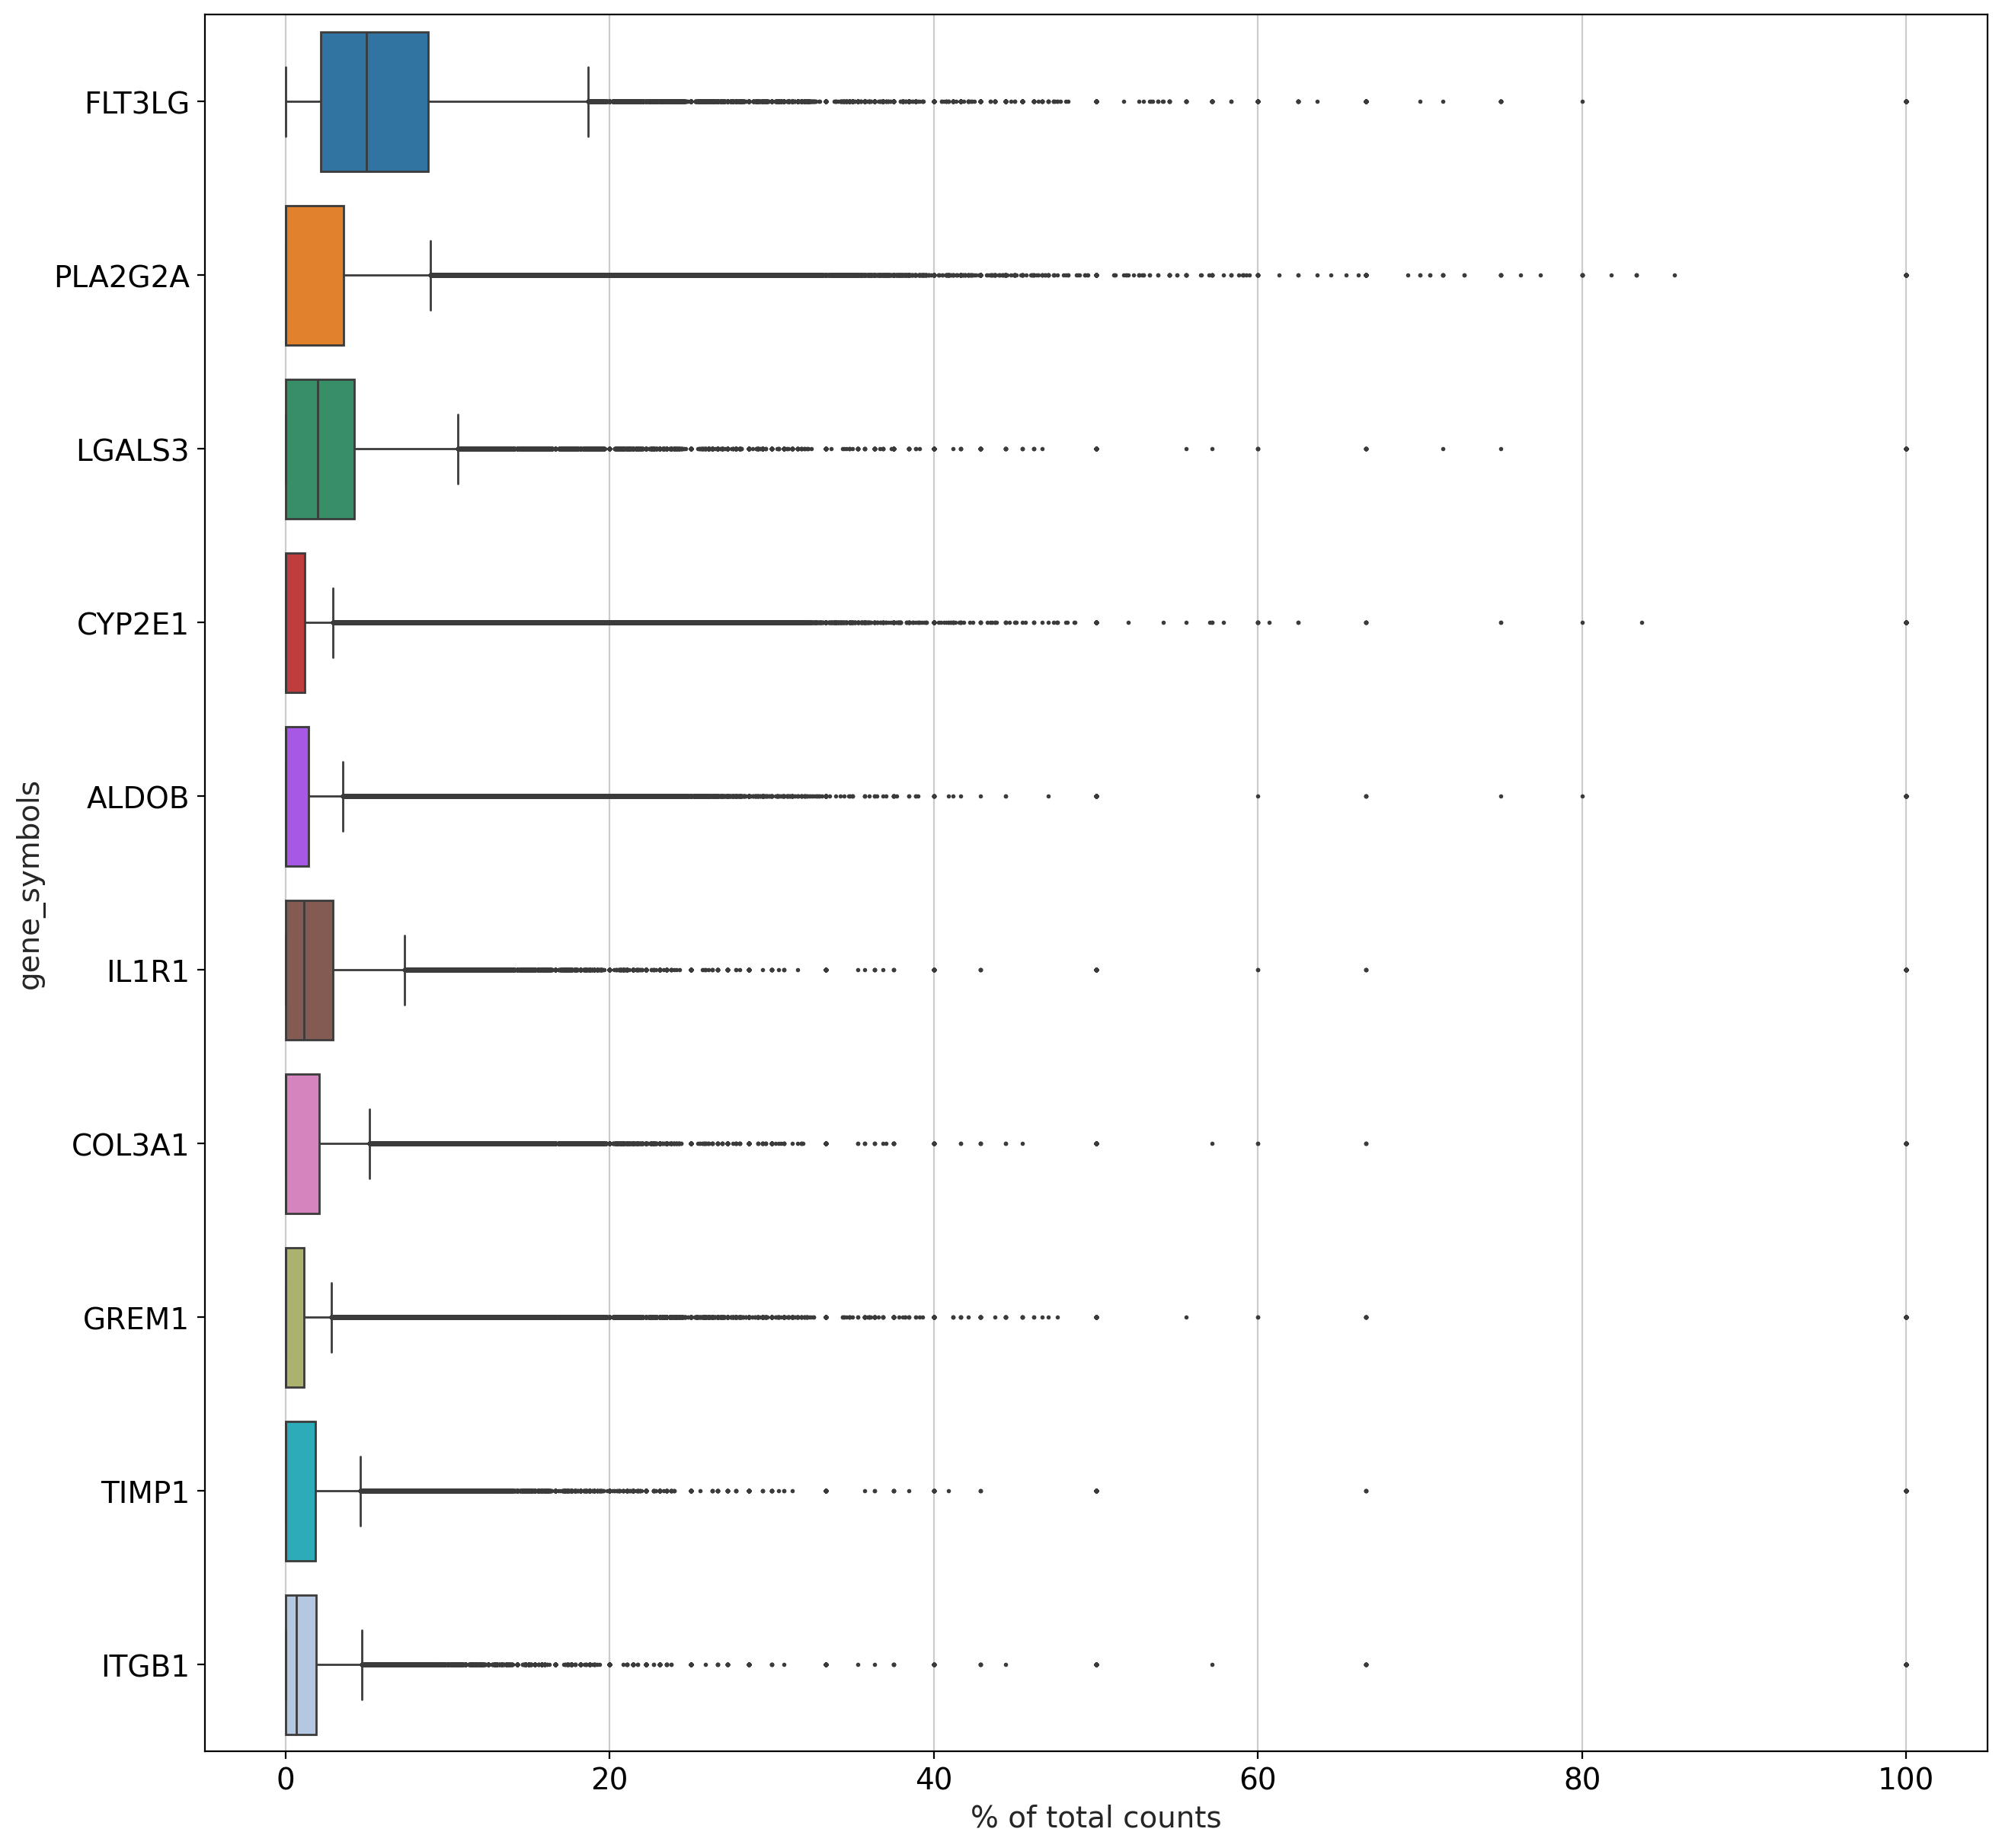



Counts: Initial


	Observations: 1104361

	Genes: 480





<<< PERFORMING QUALITY CONTROL ANALYSIS>>>

	*** Detecting Mitochondrial, Ribosomal, Hemoglobin genes...

	*** Calculating & plotting QC metrics...




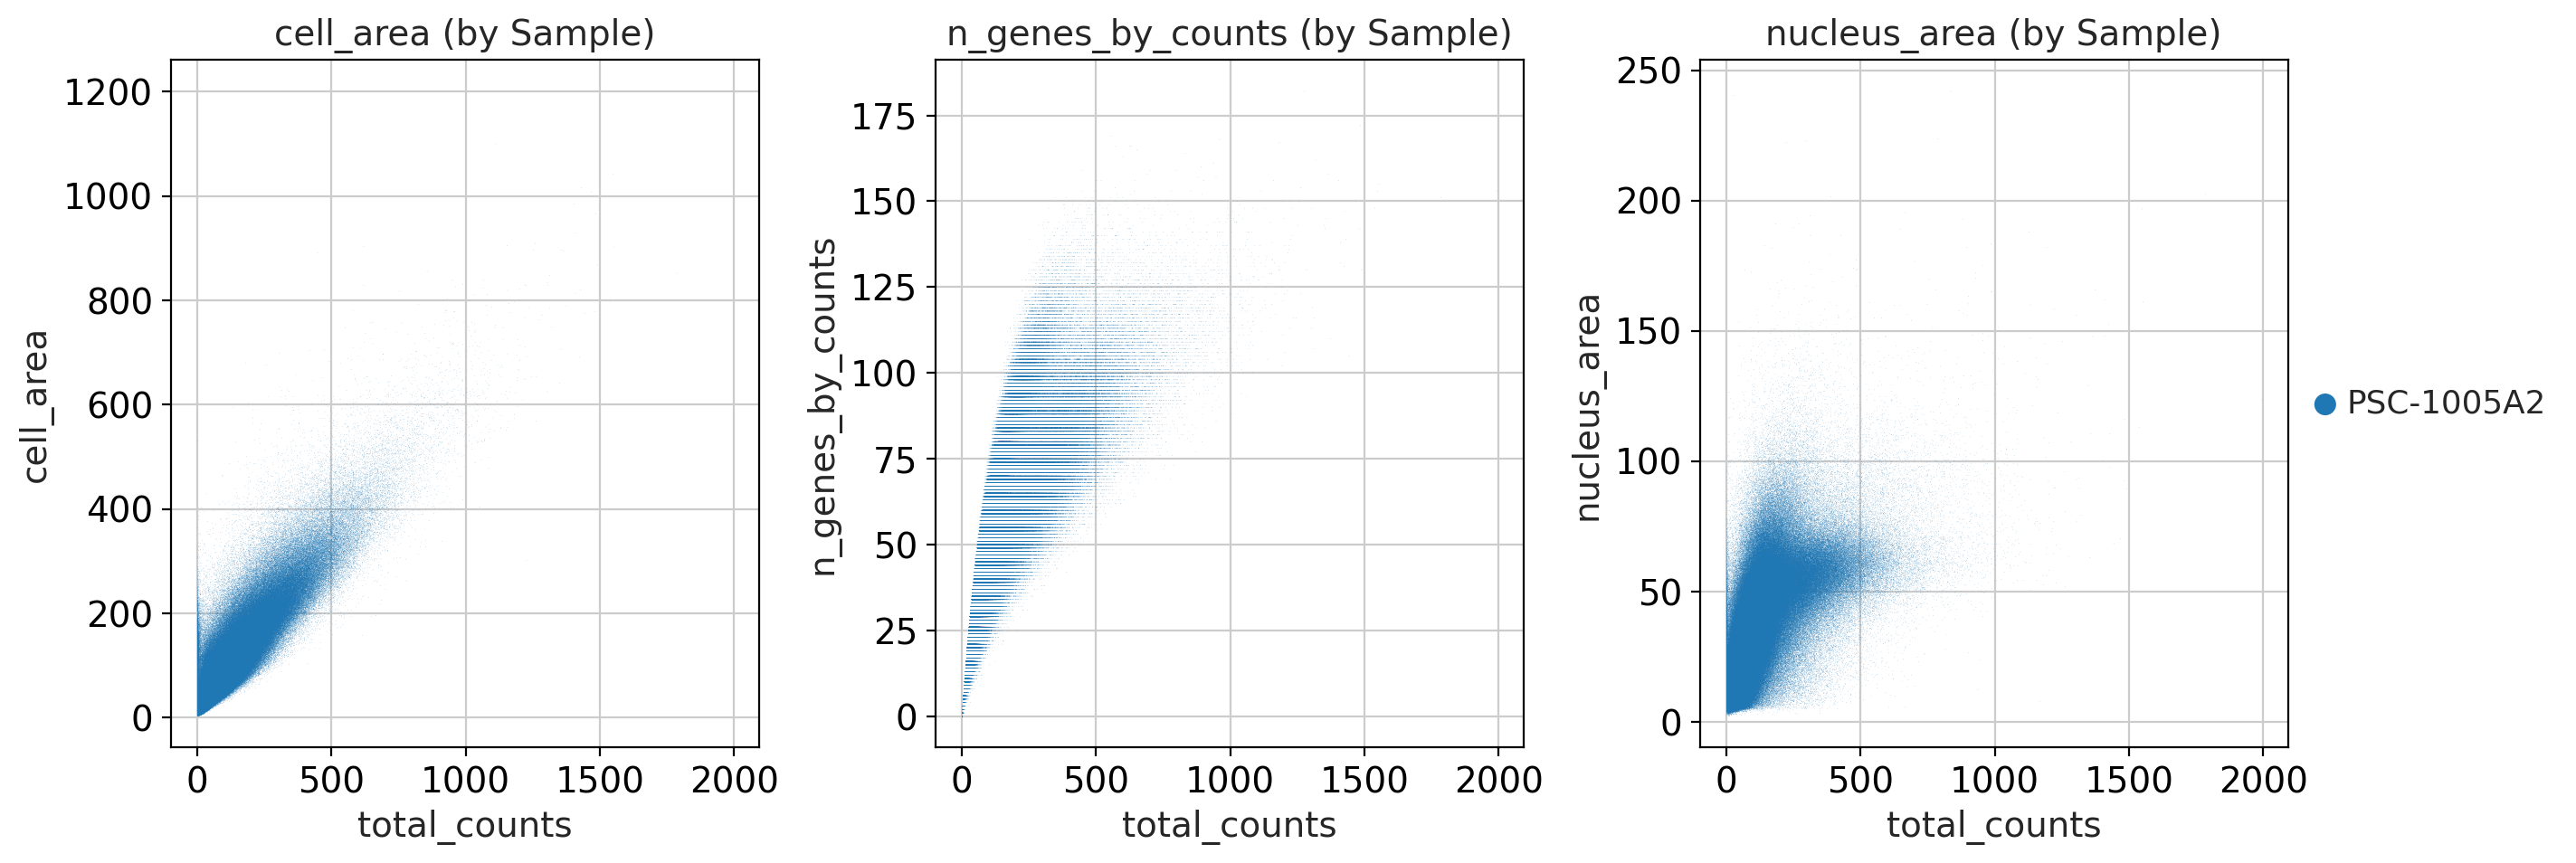


<<< FILTERING CELLS (TOO FEW GENES) & GENES (TOO FEW CELLS) >>>


Counts: Post-`min_gene`


	Observations: 1097168

	Genes: 480

     n_cells_by_counts  mean_counts  log1p_mean_counts  pct_dropout_by_counts  \
25%            19629.5     0.021646           0.021415              86.698281   
50%            57907.0     0.070408           0.068040              94.756515   
75%           146899.0     0.206549           0.187764              98.222547   

     total_counts  log1p_total_counts  
25%      23904.50           10.081833  
50%      77755.50           11.261336  
75%     228104.25           12.337562  





Counts: Post-`min_cell`


	Observations: 1097168

	Genes: 480

     n_cells_by_counts  mean_counts  log1p_mean_counts  pct_dropout_by_counts  \
25%            19629.5     0.021646           0.021415              86.698281   
50%            57907.0     0.070408           0.068040              94.756515   
75%           146899.0     0.206549           0.187764              98.222

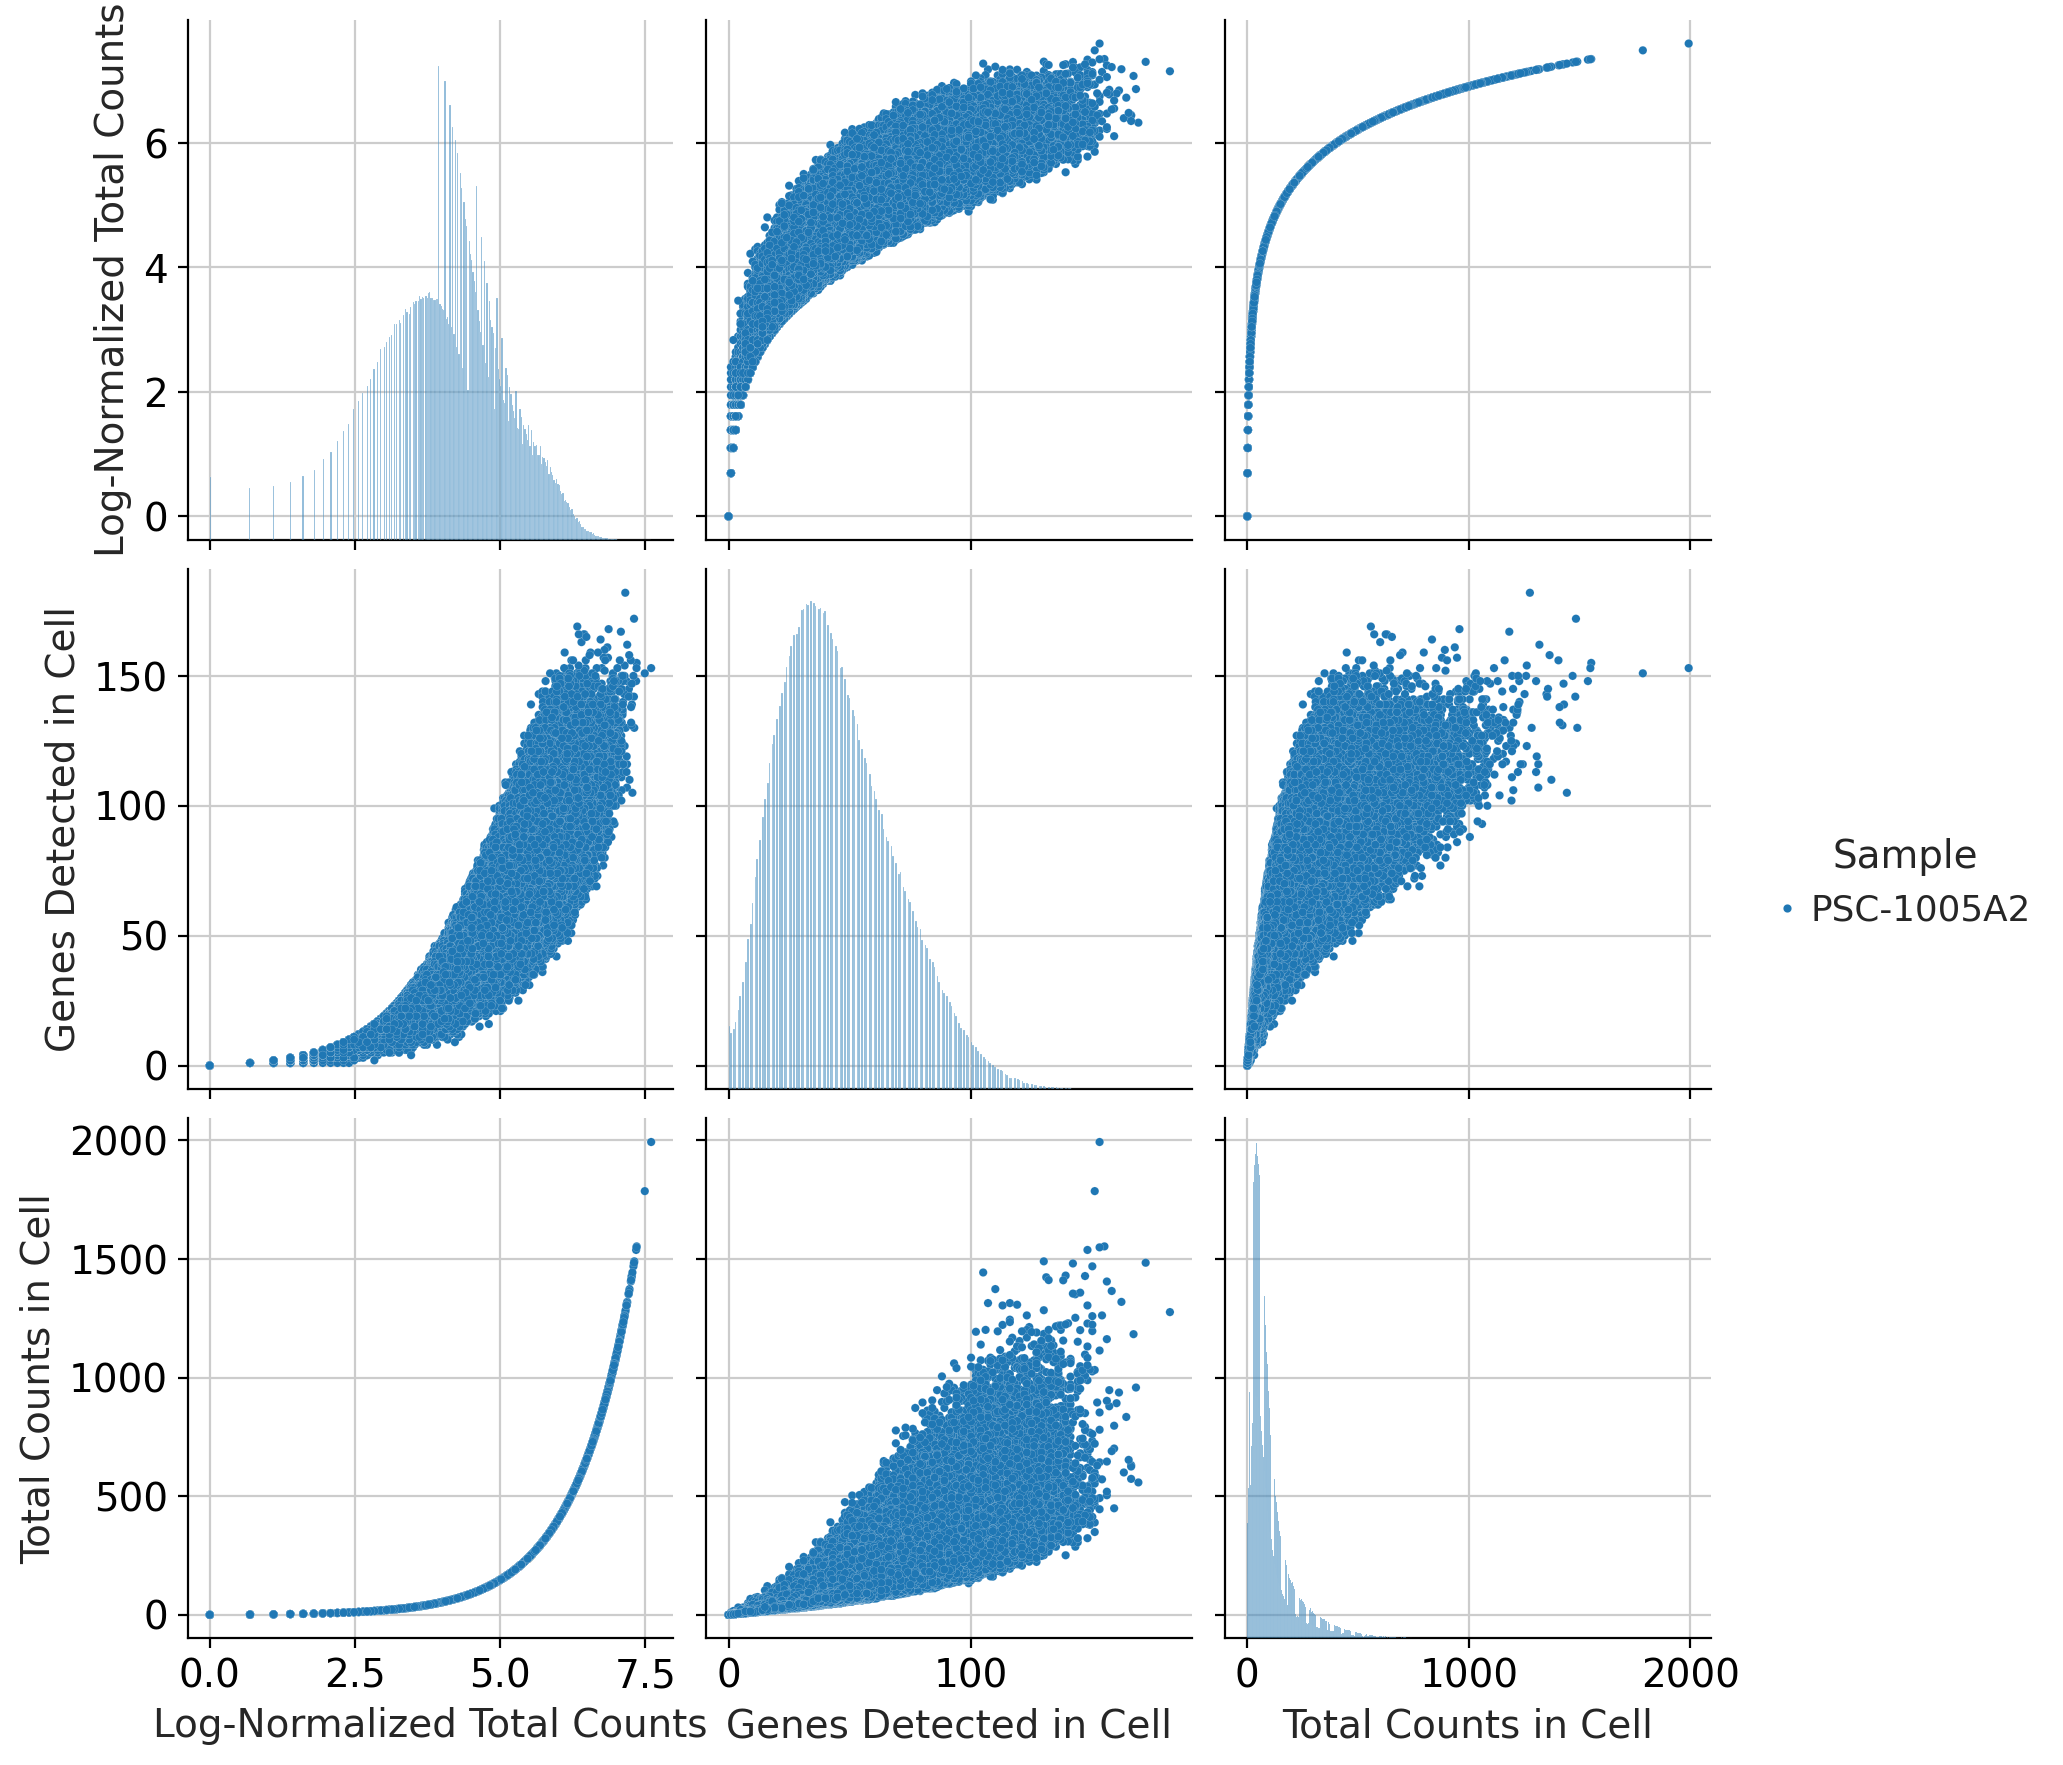

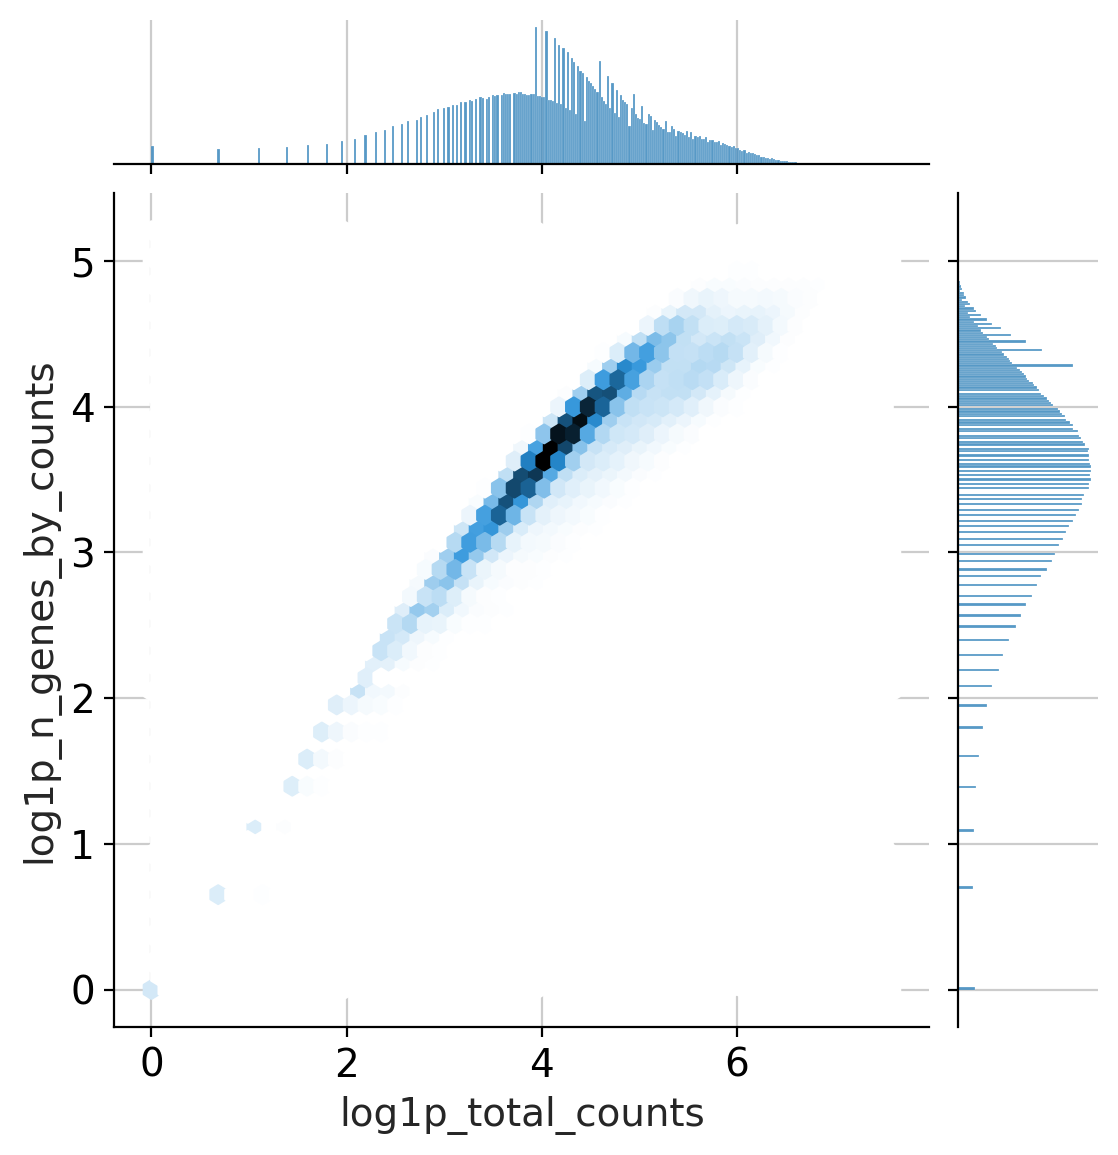

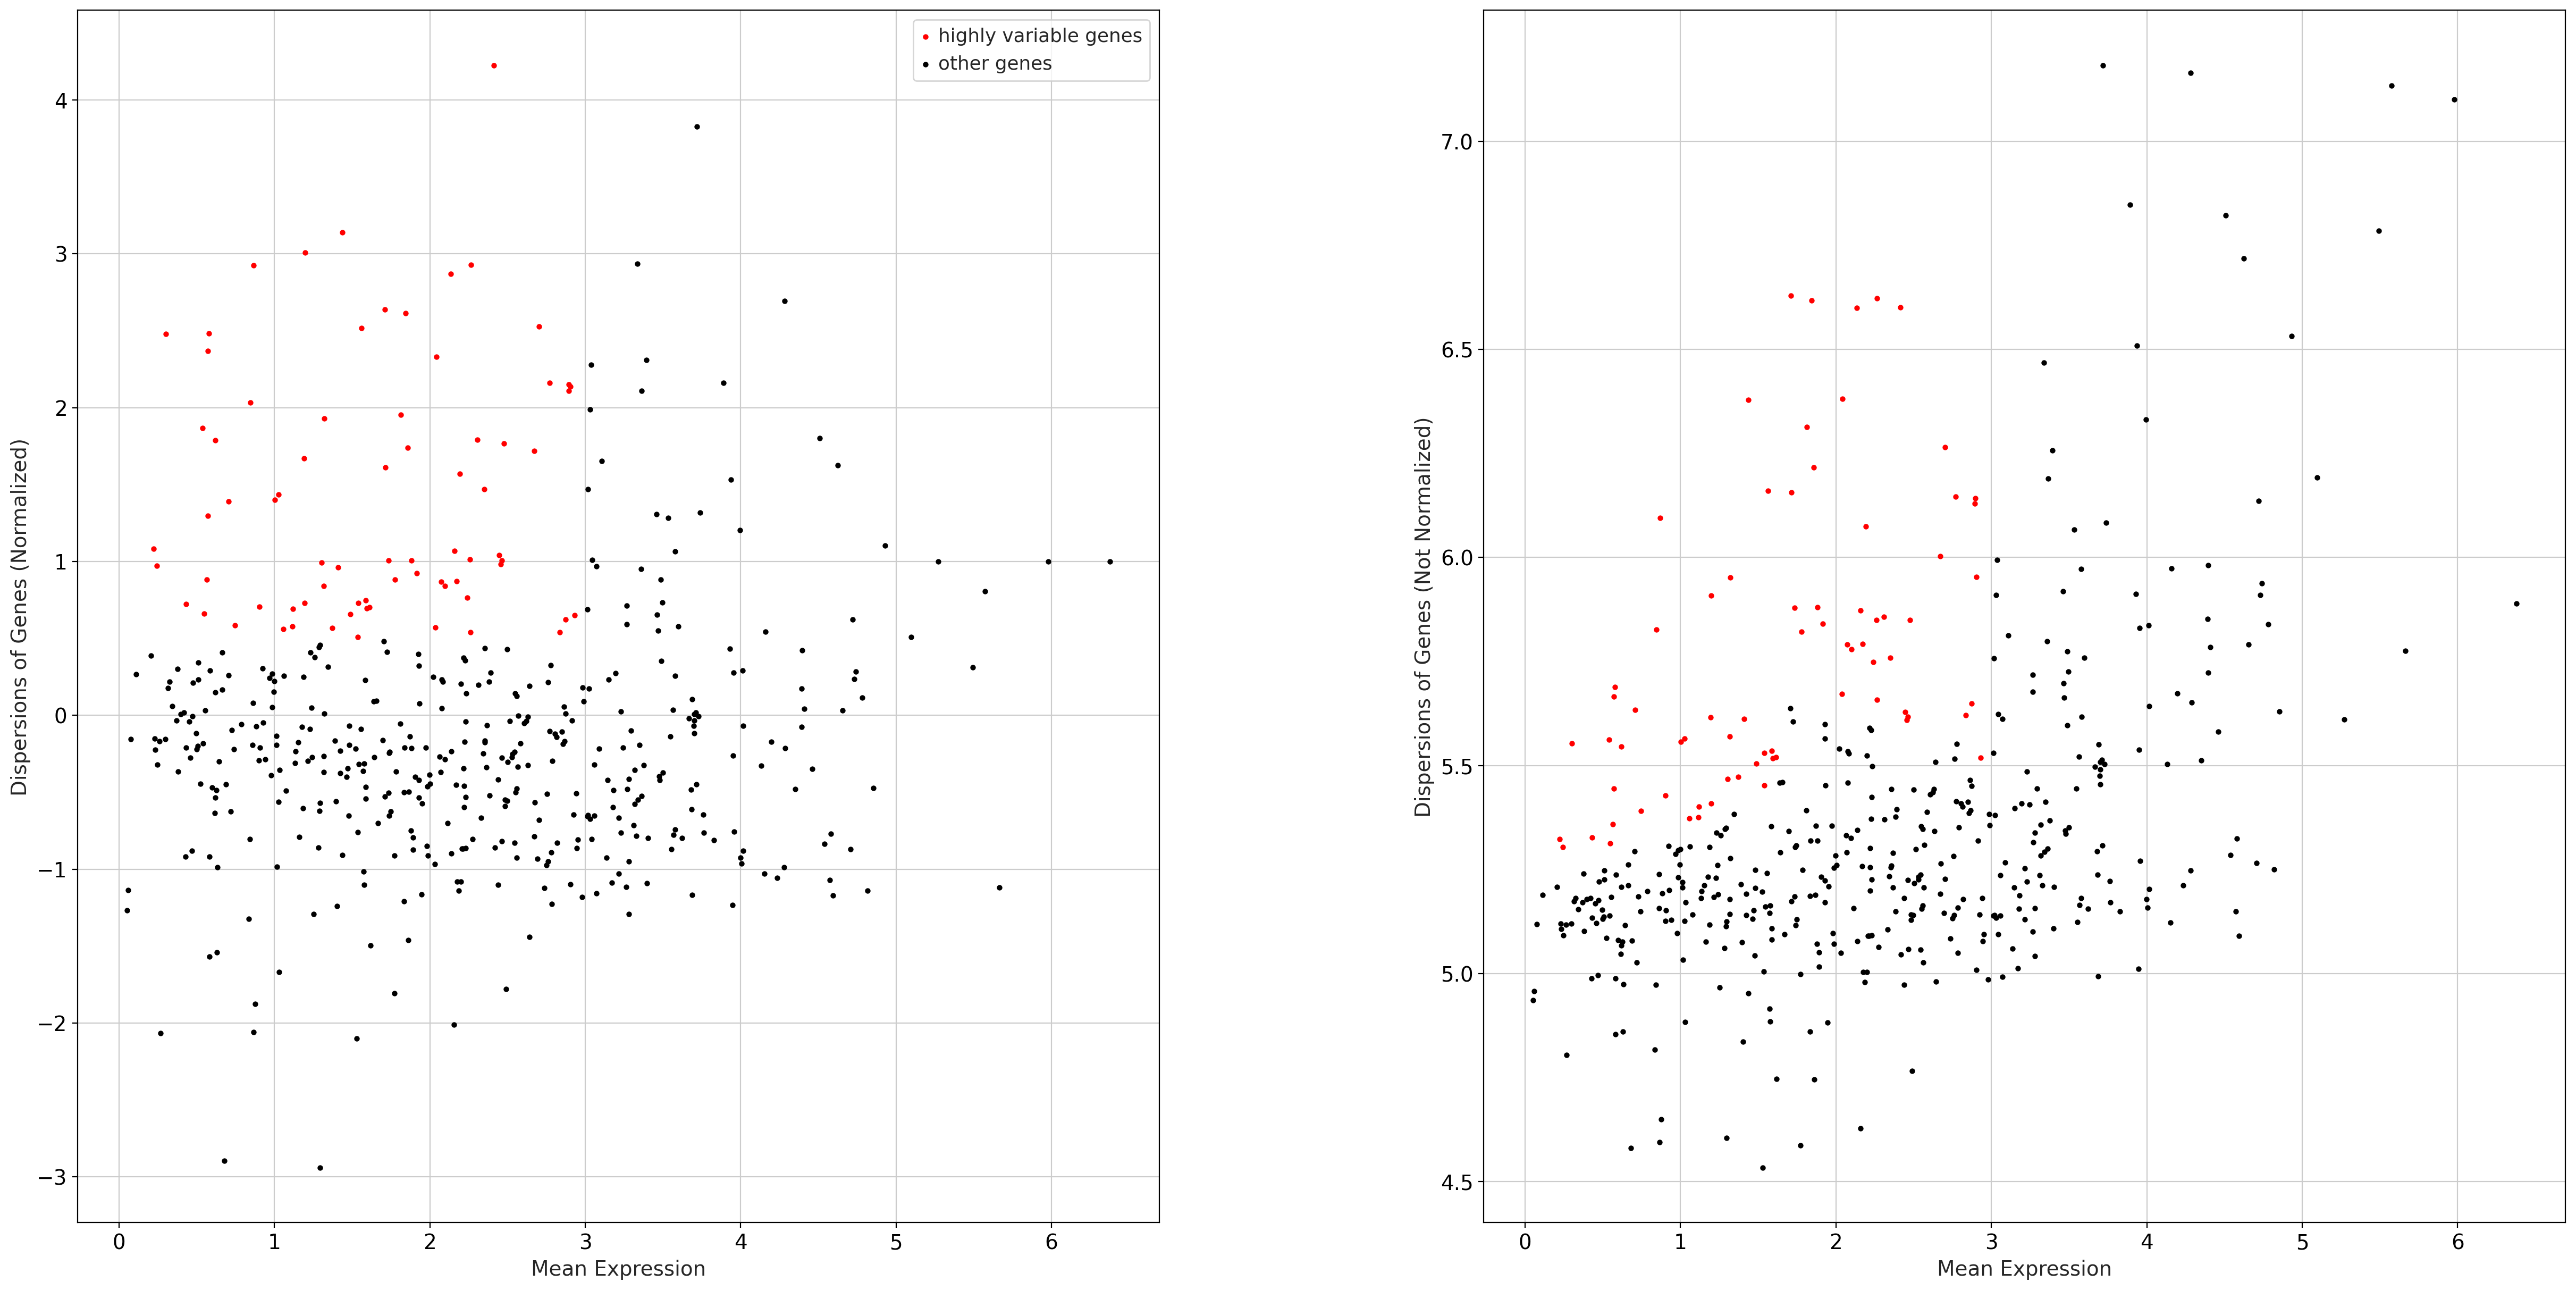


<<< NORMALIZING RAW GENE EXPRESSION >>>

	*** Scaling gene expression...

	*** Clipping maximum GEX SD to 10...

	*** Scaling => `.X` & scaled layer...


Counts: Post-Processing


	Observations: 970234

	Genes: 480

     n_cells_by_counts  mean_counts  log1p_mean_counts  pct_dropout_by_counts  \
25%            19629.5     0.021646           0.021415              86.698281   
50%            57907.0     0.070408           0.068040              94.756515   
75%           146899.0     0.206549           0.187764              98.222547   

     total_counts  log1p_total_counts    n_cells  n_counts     means  \
25%      23904.50           10.081833   19158.75   23218.5  1.289795   
50%      77755.50           11.261336   56581.00   75984.5  2.203225   
75%     228104.25           12.337562  141550.50  223302.5  3.094115   

     dispersions  dispersions_norm      mean       std  
25%     5.142038         -0.598816  0.088975  0.642149  
50%     5.282293         -0.171201  0.264678  1.089172 

OSError: Cannot save file into a non-existent directory: '/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/XR4UZH/nebraska/find_markers'

In [45]:
%%time

for i, s in enumerate(selves):
    f_o = None if out_dir is None else str(s.rna.obs[col_object].iloc[0])

    # Preprocessing
    if kws_pp is not None:
        print("\n\n", kws_pp, "\n\n")
        _ = s.preprocess(**kws_pp, figsize=(15, 15))  # preprocess
    else:
        print(f"\n\n***** Using Prior Preprocessing\n\n{s.rna.obs.iloc[[0]]}")

    # Clustering at Different Resolutions & Minimum Distances & # of PCs
    for j, x in enumerate(kws_clustering):

        # Variables & Output Files
        print(f"\n\n{'=' * 80}\n{x}\n{'=' * 80}\n\n")
        cct, cca = f"leiden_{x}", f"label_{x}"  # Leiden & annotation columns

        # Clustering & Find Markers
        _ = s.cluster(**kws_clustering[x], key_added=cct, out_file=f_o)
        _ = s.find_markers(col_cell_type=cct, kws_plot=False)  # DEGs

        # Annotation
        if assign is not None:  # annotate by marker list
            _ = s.annotate_clusters(assign[[col_assignment[j]]],
                                    col_cell_type=cct, col_annotation=cca)

        # Create Xenium Explorer Cluster Files
        if out_dir is not None:
            for c in [k for k in [cct, cca] if k in s.rna.obs]:  # Explorer
                s.write_clusters(out_dir, col_cell_type=c, overwrite=True,
                                file_prefix=f"{s._library_id}__",
                                n_top=out_subdir_markers)

        # Write Final Object
        if out_dir is not None:
            s.write(f_o)

# Plot Clusters

## Plot Clusters Individually (Save in Same PDF if `out_dir` is not None)

In [46]:
for i, s in enumerate(selves):
    for x in kws_clustering:
        print(f"\n\n{'=' * 80}\n{x}\n{'=' * 80}\n\n")
        cct, cca =   # Leiden & annotation columns
        for c in [f"leiden_{x}", f"label_{x}", f"manual_{x}"]:
            if c not in s.rna.obs:
                print(f"\n\n{c} not in {s.rna.obs.columns}.\n\n")
            if out_dir_plot is not None:
                pfp = os.path.join(out_dir_plot, s._library_id, f"{c}.pdf")
                s.plot_clusters(col_cell_type=c, out_dir=pfp, multi_pdf=True)

SyntaxError: invalid syntax (3783235378.py, line 4)

## Plot Clusters (Overall; No Save)

In [ ]:
for s in selves:
    for j, x in enumerate(kws_clustering):
        _ = s.plot_spatial(color=list(set([
            f"leiden_{x}", f"label_{x}"]).intersection(s.rna.obs.columns)))

# Spatially-Informed Clustering (Optional)

In [ ]:
if kws_clustering_spatial is not None:
    for s in selves:
        f_o = None if out_dir is None else str(s.rna.obs[col_object].iloc[0])
        cct = f"leiden_spatial_{suffix_clustering_spatial}"
        _ = s.cluster_spatial(key_added=cct, **kws_clustering_spatial)
        _ = s.find_markers(col_cell_type=cct, kws_plot=False)
        _ = s.annotate_clusters(assign[[col_assignment[-1]]], col_cell_type=cct,
                                col_annotation=f"annotation_{cct}")
        for c in [cct, f"annotation_{cct}"]:
            s.plot_spatial(c)
            if out_dir is not None:
                s.write_clusters(out_dir, col_cell_type=c, overwrite=True,
                                file_prefix=f"{s._library_id}__",
                                n_top=out_subdir_markers)
        if out_dir is not None:
            s.write(f_o)

# Analyze

The first clustering version (first specified in `res_list`) is the cell type column used by default in downstream analyses (because it was specified in `kws_init["col_cell_type"]` when creating the object and thus is stored in `self._columns["col_cell_type"]`). Specify `col_cell_type` as an argument in the following functions to use a different column.

## Centrality Scores

In [ ]:
%%time

for s in selves:
    s.calculate_centrality(n_jobs=sc.settings.n_jobs)

## Neighborhood Enrichment Analysis

In [ ]:
%%time

for s in selves:
    _ = s.calculate_neighborhood(figsize=(60, 30))

## Cell Type Co-Occurrence

In [ ]:
%%time

for s in selves:
    _ = s.find_cooccurrence(figsize=(60, 20), kws_plot=dict(wspace=3))

## Spatially-Variable Genes

In [ ]:
%%time

kws = dict(kws_plot=dict(legend_fontsize="large"), figsize=(15, 15))
for s in selves:
    _ = s.find_svgs(genes=15, method="moran", n_perms=10, **kws)

## GEX

In [ ]:
# for s in selves:
#     s.plot_spatial(color=["TNF", "IL23", col_cell_type])